<p align="center">
    <img src="https://gitlab.epfl.ch/center-for-imaging/eias-2023-visualization-workshop/-/raw/main/images/tracking_fig.png" height="350" alt="tracking image">
</p>

# Cell detection and tracking
---

This notebook gives a practical introduction to blob detection and particle tracking in the context of a 2D cell lineage tracing challenge. It was adapted from an example from `napari.org` which you can check out here: [Single cell tracking with napari](https://napari.org/stable/tutorials/tracking/cell_tracking.html).

### Setup

First, check that you have all the necessary packages installed, including `napari`, `trackpy`, and `ipywidgets`. If not, you can use the `!` symbol to install them directly from the Jupyter notebook (otherwise, you can use your terminal).

In [2]:
import napari
import trackpy as tp

### Get the data

The image we'll use in this tutorial is available for download on [Zenodo](https://zenodo.org/record/8099852) (`cell_tracking_2d.tif`). This image comes from the [cell tracking challenge](http://celltrackingchallenge.net/3d-datasets/).

In the cell below, we use a Python package called [pooch](https://pypi.org/project/pooch/) to automatically download the image from Zenodo into the **data** folder of this repository.

In [3]:
import pooch
from pathlib import Path

data_path = Path('.').resolve().parent / 'data'
fname = 'cell_tracking_2d.tif'

pooch.retrieve(
    url="https://zenodo.org/record/8099852/files/cell_tracking_2d.tif",
    known_hash="md5:43f973785dcfbad38334fbf682a36d0f",
    path=data_path,
    fname=fname,
    progressbar=True,
)

print(f'Downloaded image {fname} into: {data_path}')

Downloaded image cell_tracking_2d.tif into: /home/wittwer/code/eias-2023-visualization-workshop/data


### Read the image

We use the `imread` function from Scikit-image to read our TIF image.

In [10]:
from skimage.io import imread

# image = imread(data_path / 'cell_tracking_2d.tif')
image = imread('/home/wittwer/data/Ella_cells/RFP_timeseries-2D-for-tracking.tif')

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape: (50, 239, 281) and data type uint16
Intensity range: [340 - 1019]


If you run into troubles, don't hesitate to ask for help 🤚🏽.

## Blob detection
---

The goal of *Blob detection* is to detect the coordinates of bright, elliptical objects on a dark background - such as the cells in our image - at a given characteristic scale.

To learn more about this topic, check out:

- [Blob detection (Scikit-image)](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html)
- [Detecting Blobs (First Principles of Computer Vision - Youtube)](https://www.youtube.com/watch?v=zItstOggP7M)

Here, we detect our cell *blobs* by applying a series of `Laplacian of Gaussian` filters to the image at different scales. The scale is defined by the parameter `sigma` (the standard deviation of the Gaussian).

We also use [Pandas](https://pandas.pydata.org/) to manipulate tabular data. To learn more about using Pandas for image data analysis, have a look at [this chapter](https://biapol.github.io/Image-data-science-with-Python-and-Napari-EPFL2022/day4a_Tabular_Data/Tabular_Data.html) from the course *Image data science with Python and Napari @EPFL*. 

In [12]:
from ipywidgets import IntProgress
from IPython.display import display  # Import and use these to display a progress bar in Jupyter
from skimage.exposure import rescale_intensity
from skimage.feature import blob_log
from skimage.transform import downscale_local_mean
import pandas as pd

# Initialize a Pandas DataFrame to collect tracks data.
df = pd.DataFrame(columns=['y', 'x', 'sigma', 'frame'])

# We downscale the image by this factor, using the local mean method.
# downscale_factor = 4
downscale_factor = 1

# We rescale the intensity to the range (0, 1) to make it easier to select a threshold for the detection.
image_normed = rescale_intensity(image, out_range=(0, 1))

# Set up the progress bar
pbar = IntProgress(min=0, max=len(image_normed))
display(pbar)

# Loop over the frames
for frame_id, frame in enumerate(image_normed):
    # We downscale the image; the cells are big enough and this will speed-up the workflow.
    im = downscale_local_mean(frame, factors=tuple([downscale_factor]*2), )

    # Tweaking the parameters for the Laplacian of Gaussian detector is necessary.
    # Eventually good parameters can be found!
    track_results = blob_log(im, 
        min_sigma=1.5, # Size of the smallest blob
        max_sigma=6.0,  # Size of the biggest blob
        threshold=0.1  # Lower = more detections
    )
    
    # Since we downscaled the image, the detected coordinates must be rescaled
    track_results[:, :3] *= downscale_factor

    ys, xs, sigmas = track_results.T  # .T for transpose => the array shape goes from (N, 4) to (4, N)
    df_frame = pd.DataFrame({
        'y': ys,
        'x': xs,
        'sigma': sigmas,
        'frame': frame_id
    })

    # Add the results of this frame to the total
    df = pd.concat([df, df_frame])  

    pbar.value += 1  # Increment the progress bar

print(f'Total number of detections: {len(df)}')

df.head() # `head` displays the first 5 elements of the data frame.

IntProgress(value=0, max=50)

Total number of detections: 278


,y,x,sigma,frame
0,159.0,176.0,1.5,0
1,170.0,145.0,1.5,0
2,81.0,213.0,1.5,0
3,172.0,204.0,1.5,0
4,185.0,196.0,1.5,0


Besides the coordinates (`x`, `y`), the value of `sigma` indicates the size of the detected "blob".

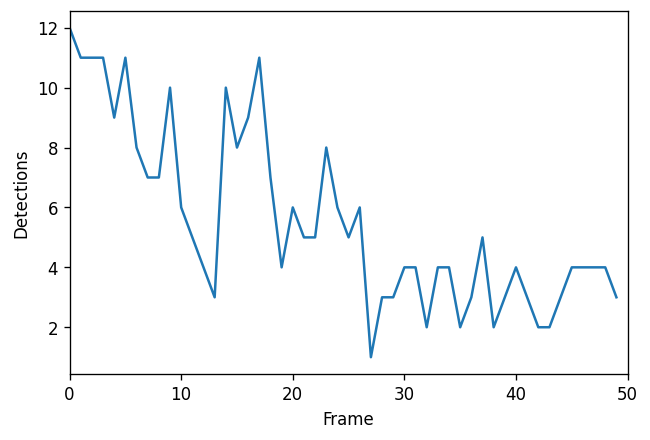

In [13]:
# A quick plot of the number of detections overtime
import matplotlib.pyplot as plt

vc = df['frame'].value_counts()  # Pandas way of counting the number of detections per frame

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.plot([vc[k] for k in range(len(image))])
ax.set_xlim(0, len(image))
ax.set_xlabel('Frame')
ax.set_ylabel('Detections')
plt.show()

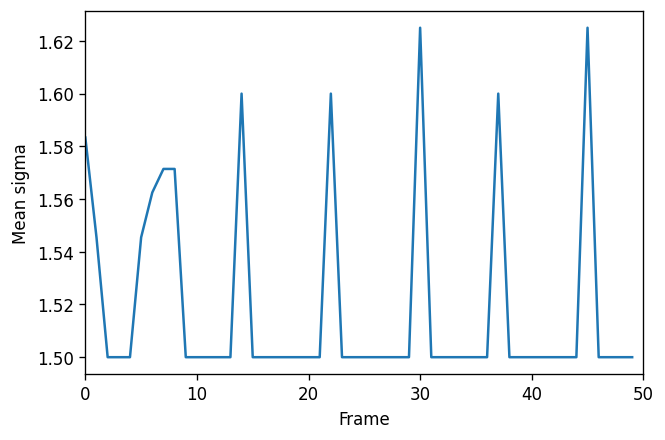

In [14]:
# Plotting the mean sigma value in every frame.. it looks like there are some peaks!
# Is the cell division synchronized?
mean_sigmas = df.groupby('frame').mean()['sigma'].values

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.plot(mean_sigmas)
ax.set_xlim(0, len(image))
ax.set_xlabel('Frame')
ax.set_ylabel('Mean sigma')
plt.show()

## Particle tracking
---

In particle tracking, we want to compute a *linkage* between objects detected in consecutive frames. In Python, [Trackpy](http://soft-matter.github.io/trackpy/v0.6.1/) is a package for particle tracking in 2D, 3D, and higher dimensions.

Here, we use the `link` function of Trackpy, which implements the [Crocker-Grier algorithm](http://dx.doi.org/10.1006/jcis.1996.0217) to compute the linkage between particles.

In [15]:
# Compute the linkage using Trackpy.
linkage_df = tp.link(df, search_range=30, memory=3)

# This line is used to add the "length" column of the DataFrame.
linkage_df = linkage_df.merge(
    pd.DataFrame({'length': linkage_df['particle'].value_counts()}), 
    left_on='particle', right_index=True
)

# The DataFrame now has a `particle` column identifying the particle ID and a `length` column corresponding to the track length.
linkage_df.head()

Frame 49: 3 trajectories present.


,y,x,sigma,frame,particle,length
0,159.0,176.0,1.5,0,0,14
6,160.0,175.0,1.5,1,0,14
4,159.0,175.0,1.5,2,0,14
5,158.0,174.0,1.5,3,0,14
2,158.0,174.0,1.5,4,0,14


## Visualization in Napari
---

The `tracks` data should be a 2D array of shape (N, 4) representing four columns: the *track ID*, *frame ID*, *Y coordinate* and *X coordinate*. With the data in this order, a [`Tracks` layer](https://napari.org/stable/howtos/layers/tracks.html) can be added for visualization using `add_tracks`.

We also add a separate [Points layer](https://napari.org/stable/howtos/layers/points.html) to visualize the results of the blob detection.

/home/wittwer/miniconda3/envs/eias/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
/home/wittwer/miniconda3/envs/eias/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:620: UserWarning: Previous color_by key 'length' not present in features. Falling back to track_id
  warn(


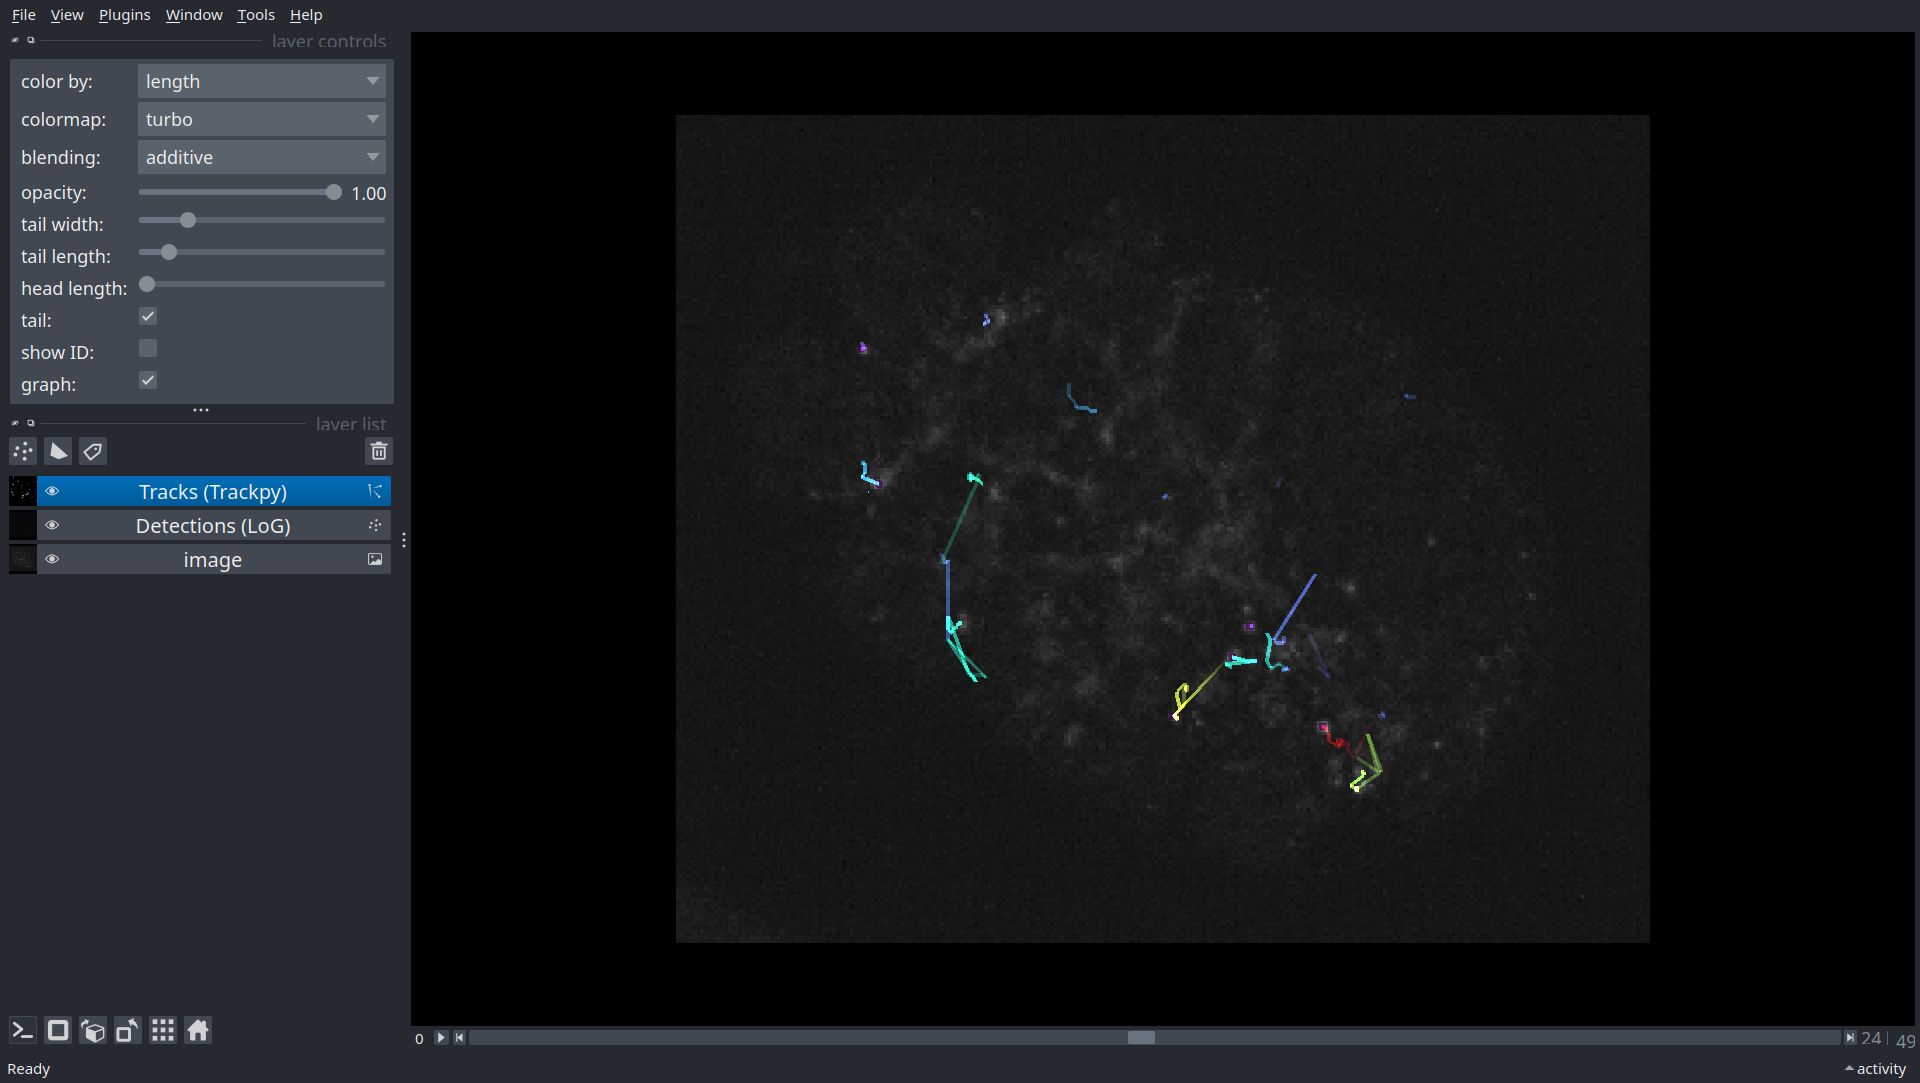

In [16]:
# Extract data for the Napari viz
points = linkage_df[['frame', 'y', 'x']].values.astype(float)
sigmas = linkage_df['sigma'].values.astype(float)
lengths = linkage_df['length'].values.astype(float)
tracks = linkage_df[['particle', 'frame', 'y', 'x']].values.astype(float)

# Create the Napari Viewer setup. `view_image`` is a shortcut for `napari.Viewer().add_image()`.
viewer = napari.view_image(image)

viewer.add_points(
    points,
    name='Detections (LoG)',
    face_color='sigma', 
    opacity=0.7, 
    edge_width=0.0, 
    size=sigmas+1,  # The size of the points can be parametrized
    features={'sigma': sigmas}  # Used to colorize the points
)

viewer.add_tracks(
    tracks, 
    name='Tracks (Trackpy)', 
    tail_width=4, 
    color_by='length', 
    properties={'length': lengths}  # Used to colorize the tracks
)

# A quick screenshot
from napari.utils import nbscreenshot
nbscreenshot(viewer)

<p align="center">
    <a href="https://gitlab.epfl.ch/center-for-imaging/eias-2023-visualization-workshop/-/blob/main/examples/README.md">🔙 Back to case studies</a>
</p>
